In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

import geopandas as gpd
import contextily as cx
from matplotlib.colors import TwoSlopeNorm

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

## 6. Make predictions on updated maps of 2024 districts.

### Data Transformation

We are going to take the same approach in creating maps as the training data, to keep the process as fair as possible.

We are making a big assumption: using the previous presidential election vote totals (as opposed to statewide totals). We feel that this is more useful when predicting the 2024 elections, and we believe that our model can transfer the same trends to presidential elections.

In [2]:
df = pd.read_csv("data\Daily Kos Elections 2020 elections - Vote totals.csv", encoding='utf-8', thousands=',')

df.head()

,District,Incumbent,Party,Biden,Trump,Total,Biden%,Trump%
0,AK-AL,Mary Peltola,(R),153778,189951,357569,43.00%,53.10%
1,AL-01,Jerry Carl,(R),117136,211370,331886,35.30%,63.70%
2,AL-02,Barry Moore,(R),107776,195953,306714,35.10%,63.90%
3,AL-03,Mike Rogers,(R),109495,212012,324741,33.70%,65.30%
4,AL-04,Robert Aderholt,(R),57133,260535,320725,17.80%,81.20%


In [3]:
# Seperate State and Congressional District - Remove unnecessary states
df["State"] = df["District"].apply(lambda x: x[:2])
df["District"] = df["District"].apply(lambda x: x[3:])
df.loc[df["District"] == "AL", "District"] = "01"

single_district_states = ["AK", "DE", "ND", "SD", "VT", "WY"]
df = df[~df["State"].isin(single_district_states)]

In [4]:
# Get partisan lean per district - negative values voted Democratic, positive values voted Republicans
df["partisan_lean"] = (df["Trump%"].str.rstrip('%').astype(float) - 50.0) / 100

Calculating efficiency gap metric

In [5]:
# Net wasted votes = (wasted votes by winning party - 50+1 majority) - all votes by losing party

def net_wasted_votes(democrat_votes, gop_votes):

    majority = math.floor((democrat_votes + gop_votes) / 2) + 1 # required votes for majority  

    if democrat_votes >= gop_votes: 
        return (democrat_votes - majority) - gop_votes 
    else: 
        return -(gop_votes - majority) + democrat_votes 

In [6]:
df["net_wasted_votes"] = df.apply(lambda x: net_wasted_votes(x["Biden"], x["Trump"]), axis=1)

df.head()

,District,Incumbent,Party,Biden,Trump,Total,Biden%,Trump%,State,partisan_lean,net_wasted_votes
1,01,Jerry Carl,(R),117136,211370,331886,35.30%,63.70%,AL,0.137,70020
2,02,Barry Moore,(R),107776,195953,306714,35.10%,63.90%,AL,0.139,63688
3,03,Mike Rogers,(R),109495,212012,324741,33.70%,65.30%,AL,0.153,58237
4,04,Robert Aderholt,(R),57133,260535,320725,17.80%,81.20%,AL,0.312,-44567
5,05,Mo Brooks,(R),129812,228398,364107,35.70%,62.70%,AL,0.127,80520


In [7]:
df_grouped = df.groupby(["State"]).agg({
    'District': 'count',
    'Biden': 'sum',
    'Trump': 'sum',
    'Total': 'sum',
    'net_wasted_votes': 'sum'
    }).reset_index()

In [8]:
df_grouped["efficiency_gap"] = round(df_grouped["net_wasted_votes"] / df_grouped["Total"], 2)

In [9]:
df_grouped = df_grouped.rename(columns={"District": "total_districts", "Biden": "total_biden_votes", 
                                        "Trump": "total_trump_votes", "Total": "total_state_votes", 
                                        "net_wasted_votes": "statewide_net_wasted_votes"})

In [10]:
df_grouped.head()

,State,total_districts,total_biden_votes,total_trump_votes,total_state_votes,statewide_net_wasted_votes,efficiency_gap
0,AL,7,849623,1441170,2315970,258397,0.11
1,AR,4,423932,760647,1219069,255577,0.21
2,AZ,9,1672143,1661686,3385294,67434,0.02
3,CA,53,11110250,6006430,17496800,-1035764,-0.06
4,CO,7,1804352,1364607,3256952,182097,0.06


In [11]:
vote_df = df.merge(df_grouped, how="left", on=["State"])

# Remove remaining single-district states - cannot be gerrymandered
vote_df = vote_df[vote_df["total_districts"] > 1]

vote_df.head()

,District,Incumbent,Party,Biden,Trump,Total,Biden%,Trump%,State,partisan_lean,net_wasted_votes,total_districts,total_biden_votes,total_trump_votes,total_state_votes,statewide_net_wasted_votes,efficiency_gap
0,01,Jerry Carl,(R),117136,211370,331886,35.30%,63.70%,AL,0.137,70020,7,849623,1441170,2315970,258397,0.11
1,02,Barry Moore,(R),107776,195953,306714,35.10%,63.90%,AL,0.139,63688,7,849623,1441170,2315970,258397,0.11
2,03,Mike Rogers,(R),109495,212012,324741,33.70%,65.30%,AL,0.153,58237,7,849623,1441170,2315970,258397,0.11
3,04,Robert Aderholt,(R),57133,260535,320725,17.80%,81.20%,AL,0.312,-44567,7,849623,1441170,2315970,258397,0.11
4,05,Mo Brooks,(R),129812,228398,364107,35.70%,62.70%,AL,0.127,80520,7,849623,1441170,2315970,258397,0.11


### Map Creation

In [12]:
geo_df = gpd.read_file("data/maps_2020/")

In [13]:
# Seperate State and Congressional District - Remove unnecessary states
geo_df["State"] = geo_df["Code"].apply(lambda x: x[:2])
geo_df["District"] = geo_df["Code"].apply(lambda x: x[3:])
geo_df.loc[geo_df["District"] == "AL", "District"] = "01"

In [14]:
# Right join to preserve GeoDataFrame object while joining all district data
df_2020 = geo_df.merge(vote_df, how="right", on=["State", "District"])

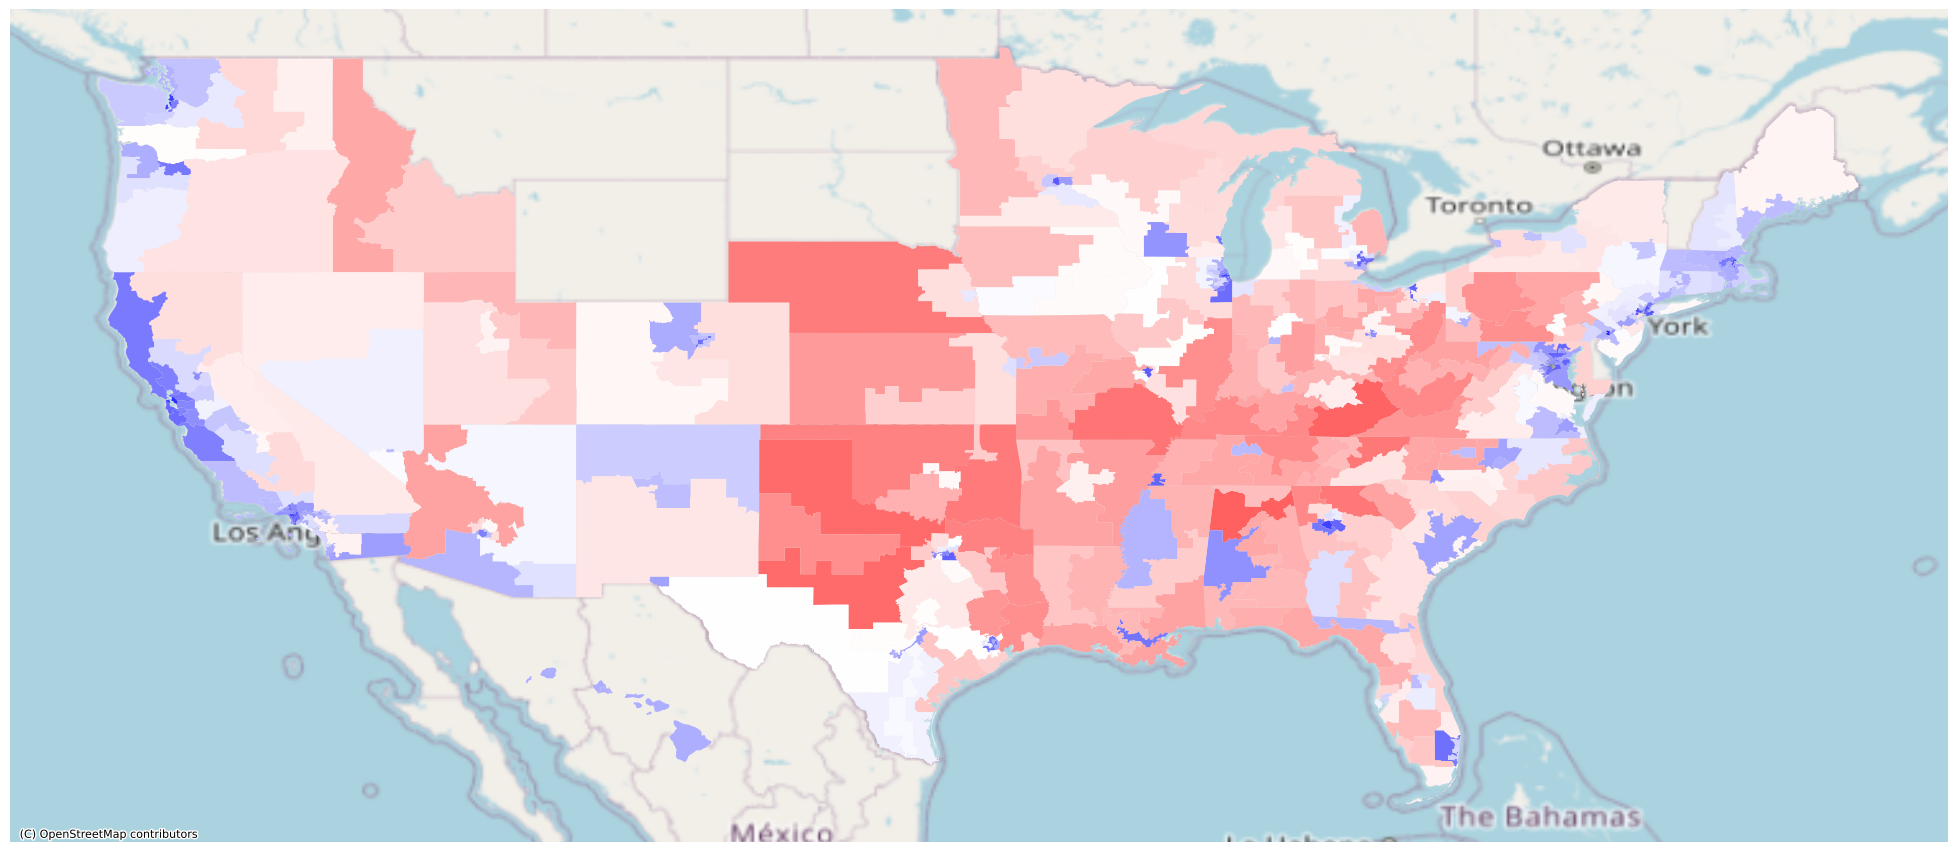

In [22]:
# Partisan Lean by Congressional District visualization in 2020 - empty states are single-district states
f, ax = plt.subplots(figsize=(25, 20))

# normalize color
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)

df_2020.plot(ax=ax, column="partisan_lean", cmap="bwr", norm=norm, missing_kwds={"color": "lightgrey"})
ax.set_axis_off()
cx.add_basemap(ax, crs=df_2020.crs, source=cx.providers.OpenStreetMap.Mapnik)  


In [272]:
# Only require new congressional district boundaries

df_2024 = gpd.read_file("data/maps_2024/")

In [273]:
df_2024["State"] = df_2024["Code"].apply(lambda x: x[:2])
df_2024["District"] = df_2024["Code"].apply(lambda x: x[3:])
df_2024.loc[df_2024["District"] == "AL", "District"] = "01"

df_2024 = df_2024[~df_2024["State"].isin(single_district_states)]
df_2024.head()

,State,District,Code,Name,GEOID,geometry
0,AL,01,AL-01,Alabama's 1st,0101,"MULTIPOLYGON (((-87.97287 31.16269, -87.97134 ..."
1,AL,02,AL-02,Alabama's 2nd,0102,"POLYGON ((-88.20770 30.61916, -88.20773 30.627..."
2,AL,03,AL-03,Alabama's 3rd,0103,"POLYGON ((-85.51361 34.52383, -85.51288 34.521..."
3,AL,04,AL-04,Alabama's 4th,0104,"POLYGON ((-86.14981 34.53363, -86.14632 34.533..."
4,AL,05,AL-05,Alabama's 5th,0105,"MULTIPOLYGON (((-86.14981 34.53363, -86.14980 ..."


<Axes: >

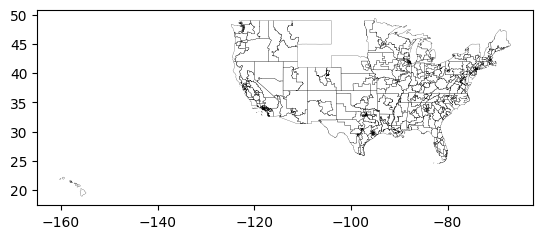

In [274]:
# Plotting 2024 congressional boundaries

f, ax = plt.subplots()

df_2024.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.15)

ax.set_axis_off()


We want to use the old dataset to preserve list of cities - we will update all of them with 2020 figures

In [275]:
# Cities + population sizes over time (every 10 yrs)
city_df = pd.read_csv("data/1790-2010_CITY_POP_MASTER.csv", index_col = "ID").iloc[:, :-4]
city_2024_df = pd.read_csv("data/USA_Major_Cities_Population_2020.csv", encoding='utf-8')

# Plotted cities have >100K residents in 2010
city_df = city_df[city_df["2010"] >= 100000].sort_values(by="2010", ascending=False)

# Merging 2020 population into existing list of cities
city_2024_df = city_2024_df[["ST", "NAME", "POPULATION"]].rename(columns={"POPULATION": "2020"})
city_df = city_df.merge(city_2024_df, how='left', left_on=["ST", "City"], right_on=["ST", "NAME"])

# Converting into GeoDataFrame to allow for plotting
city_df = gpd.GeoDataFrame(city_df, geometry=gpd.points_from_xy(city_df.LON, city_df.LAT), crs="EPSG:4326")

print(city_df.shape)
city_df.head()

(274, 36)


,ST,City,CityST,1790,1800,1810,1820,1830,1840,1850,...,STPLFIPS_2010,Name_2010,County,LAT,LON,LAT_BING,LON_BING,NAME,2020,geometry
0,NY,New York City,"New York City, NY",33131.0,60515.0,96373.0,123706.0,202589.0,312710.0,515547.0,...,3651000.0,New York city,NEW YORK,40.664274,-73.938500,40.7820014953613,-73.832703,New York City,8691599,POINT (-73.93850 40.66427)
1,CA,Los Angeles,"Los Angeles, CA",0.0,0.0,0.0,0.0,0.0,0.0,1610.0,...,644000.0,Los Angeles city,LOS ANGELES,34.019394,-118.410825,34.0534896850585,-118.245323,Los Angeles,3986442,POINT (-118.41082 34.01939)
2,IL,Chicago,"Chicago, IL",0.0,0.0,0.0,0.0,0.0,4470.0,29963.0,...,1714000.0,Chicago city,COOK,41.837551,-87.681844,41.8842506408691,-87.632446,Chicago,2781116,POINT (-87.68184 41.83755)
3,TX,Houston,"Houston, TX",0.0,0.0,0.0,0.0,0.0,0.0,2400.0,...,4835000.0,Houston city,HARRIS,29.780472,-95.386342,29.7604503631591,-95.369781,Houston,2333285,POINT (-95.38634 29.78047)
4,PA,Philadelphia,"Philadelphia, PA",28522.0,41220.0,53722.0,63802.0,80462.0,93665.0,121376.0,...,4260000.0,Philadelphia city,PHILADELPHIA,40.009375,-75.133346,39.952278137207,-75.162453,Philadelphia,1587761,POINT (-75.13335 40.00938)


#### Single Map

Let's test a map of California with our new layers.

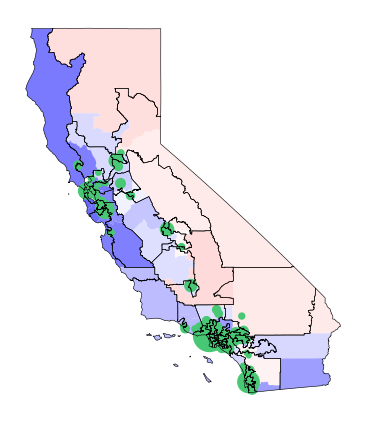

In [277]:
# New California districts (2024) on top of 2020 district voting results, cities labelled depending on size
px = 1/96
f, ax = plt.subplots(figsize=(500*px, 500*px))

# Layer 1: Plot 2010 district voting results 
# normalize color
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
df_2020[df_2020["State"]=="CA"].to_crs(df_2020.crs).plot(column="partisan_lean", cmap="bwr", norm=norm, missing_kwds={"color": "lightgrey"}, ax=ax)

# Layer 2: Plot points for cities depending on 2020 census population
# Artificial scaler as markersize: (val-min)/(max-min)
city_df[city_df["ST"]=="CA"].plot(ax=ax, aspect=1, color="#48c774", markersize=((city_df["2020"]-city_df["2020"].min()) / (city_df["2020"].max()-city_df["2020"].min()))*(50000*px))

# Layer 3: Plot 2012 congressional district boundaries
df_2024[df_2024["State"]=="CA"].plot(ax=ax, facecolor="none", edgecolor="black", linewidth=40*px)

ax.set_axis_off()
plt.show()

#### Creating all maps

In [ ]:
for state in list(df_2024["State"].value_counts().index):

    try:
        # STEP 1: save in format: [map_no (4 digit)][year][state]
        tag = "_".join(["2024", state])
        print(tag)


        # STEP 2: create map for each state
        f, ax = plt.subplots()
        f.set_size_inches(2, 2)

        # Layer 1: Plot 2020 district voting results 
        # normalize color
        norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
        df_2020[df_2020["State"]==state].to_crs(df_2020.crs).plot(column="partisan_lean", cmap="bwr", norm=norm, missing_kwds={"color": "lightgrey"}, ax=ax)

        # Layer 2: Plot points for cities depending on 2010 census population
        # Artificial scaler as markersize: (val-min)/(max-min)
        city_df[city_df["ST"]==state].plot(ax=ax, aspect=1, color="#48c774", markersize=((city_df["2020"]-city_df["2020"].min()) / (city_df["2020"].max()-city_df["2020"].min()))*20)

        # Layer 3: Plot 2012 congressional district boundaries
        df_2024[df_2024["State"]==state].plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.15)

        ax.set_axis_off()
        plt.savefig(f"output/maps/{tag}.png", dpi=200)
    
    except ValueError:
        continue
    



## Making Predictions

In [36]:
# Load model
model = load_model('model/baseline_model.keras')

In [37]:
pred_img_path = "output/maps/"

states_list = ['CA', 'TX', 'FL', 'NY', 'IL', 'PA', 'OH', 'GA', 'NC', 'MI', 'NJ', 'VA', 'WA', 'AZ', 
'IN', 'TN', 'MA', 'MO', 'CO', 'MN', 'MD', 'WI', 'SC', 'AL', 'LA', 'OR', 'KY', 'OK', 'CT', 'KS', 'IA', 
'AR', 'MS', 'UT', 'NV', 'NE', 'NM', 'RI', 'ID', 'HI', 'WV', 'ME', 'MT', 'NH']

pred_dict = {}
class_name = ['D', 'NC', 'R']

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.36045513 0.34197518 0.2975697 ]]
Predicted class: D


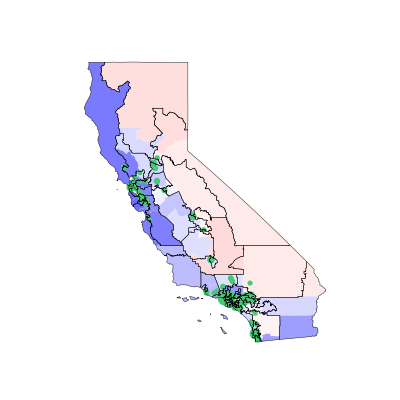

In [38]:
# Example Prediction
img = image.load_img("".join([pred_img_path, "2024_CA.png"]), target_size=(400, 400))  # Adjust target_size as per your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

prediction = model.predict(img_array)
predicted_index = np.argmax(prediction, axis=-1)  # Get the index of the highest probability
predicted_class = class_name[predicted_index[0]] 
print(prediction)
print(f'Predicted class: {predicted_class}')
img

In [ ]:
for state in states_list:
    tag = "_".join(["2024", state])
    try:
        # Load image
        img = image.load_img("".join([pred_img_path, tag, ".png"]), target_size=(400, 400))  # Adjust target_size as per your model's input size
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        prediction = model.predict(img_array)
        predicted_index = np.argmax(prediction, axis=-1)  # Get the index of the highest probability
        predicted_class = class_name[predicted_index[0]] 
        pred_dict[tag] = predicted_class
    except FileNotFoundError:
        continue

In [40]:
pred_df = pd.DataFrame(pred_dict, index=["pred"]).T.reset_index().rename(columns={"index":"tag"})
pred_df.to_csv("output/prediction_results.csv")

In [41]:
pred_df.value_counts("pred")

pred
D     42
NC     1
Name: count, dtype: int64

Our model is predicting a huge wave of Democratic gerrymandering! 

Our model predicted **42 Democratic gerrymandered states**, **1 states with no change**, and **0 Republican gerrymandered states** for the 2021 redistricting case; this would theoretically indicate a landslide win for Biden (by at least 84 votes if every gerrymandered state flipped 1 state), which would obviously be untrue.  

There exists some bias within the model to prefer Democratic gerrymandering - some tuning of the maps might fix this.

In reality, it's a sign of a terrible model - all 3 probabilities from softmax are incredibly close, indicating a difficulty in seperating between all 3 classes.

In [42]:
results = pd.DataFrame({
    "Outcomes": ["Dem Gerrymander", "No Change", "Rep Gerrymander"],
    "States": [42, 1, 0]
})

C:\Users\tobyt\AppData\Local\Temp\ipykernel_37448\1633909065.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x=results["Outcomes"], y=results["States"], palette=["cornflowerblue", "gray", "lightcoral"])


Text(0.5, 1.0, 'Predicted Gerrymandering Swings for 2021 Redistricting')

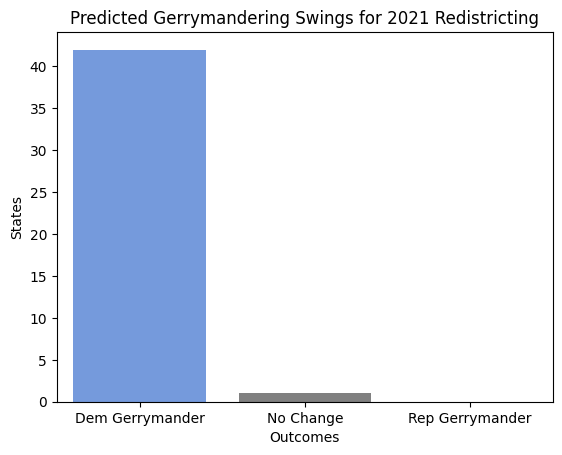

In [43]:
g = sns.barplot(x=results["Outcomes"], y=results["States"], palette=["cornflowerblue", "gray", "lightcoral"])
g.set_title("Predicted Gerrymandering Swings for 2021 Redistricting")